C:\Users\Adachi Takashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: This function is deprecated. Please call randint(-3, 6 + 1) instead


E = 1


  2% (2448 of 100000) |                  | Elapsed Time: 0:00:00 ETA:   0:00:08

Agents condition after iteration
Agents 0 [5.15524835]
Agents 1 [5.15510589]
Agents 2 [5.15513343]
objective function : -20.592081520000022
objective function estimated by Agent : [-20.39467703]
difference : [-0.23126874]
E = 1.5


Agents condition after iteration
Agents 0 [-2.45543509]
Agents 1 [-2.45542814]
Agents 2 [-2.45543563]
objective function : -20.592081520000022
objective function estimated by Agent : [-20.16103923]
difference : [-0.43122794]
E = 0.5


 99% (99864 of 100000) |################ | Elapsed Time: 0:00:08 ETA:   0:00:00

Agents condition after iteration
Agents 0 [-2.35818383]
Agents 1 [-2.35816536]
Agents 2 [-2.35817666]
objective function : -20.592081520000022
objective function estimated by Agent : [-22.02431027]
difference : [1.43165412]


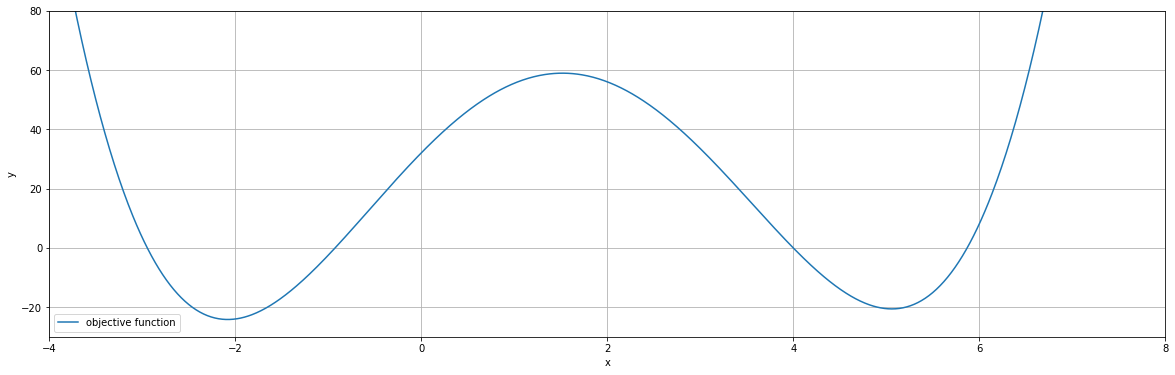

In [8]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LN
import networkx as nx
import copy

from progressbar import ProgressBar

# =========================================================================== #
#コード作成の順番
"""
1: Agent_subgrad(object)のclassを作る
2: 各パラメータの値を決定
3: agentの関数の決定．
4: 固定連結無向グラフを作成・プロット
5: 重み行列の決定
6: Initialization
7: Plot the initial estimation
8: アルゴリズムの構築
9: グラフのプロット
10: 収束しているかの確認

目的関数
    F(z) = F_1(z) + F_2(z) + F_3(z)
    F_1(z) = 2z^2
    F_2(z) = 3z~2 + 2z
    F_3(z) = 4z^2 + 2
"""
# =========================================================================== #
#classの設定
class Agent_gradient(object):
    #def __init__() : エージェントの勾配に必要な，変数をAgent_gradient classが持つself変数に代入する
    def __init__(self, N, n, weight, name, stepsize, eventtrigger):
        self.N = N #agentの数
        self.n = n #agentの持つ変数の次元
        #self.agent = agent #agentの持つ費用関数を渡す
        self.name = name
        self.weight = weight
        self.stepsize = stepsize
        self.eventtrigger = eventtrigger

        self.initial_state()

    #Initialization : agentの初期状態を決定する
    def initial_state(self):
        self.z_i = np.random.random_integers(-3, 6) #agentのcost functionの決定変数
        self.z = np.zeros([self.N, self.n])
        self.z_send = np.zeros([self.N, self.n])
        
    #Compute the gradient 非凸での勾配を考える．
    def grad(self, i, x):
        if i == 0:
            return (-3*2*x*(x+2)-3*(x**2-16))
        elif i == 1:
            return ((1.5*x**2+2*x)*(x-4)+(0.5*x**3+x**2))
        elif i == 2:
            return ((2*(x+4)+(x+4)**2))
    
    #Compute the step-size
    def step_size(self, t, stepsize):
        return stepsize / (t+1)

    #Send the state to the neighbor agents　
    def send(self, j):
        self.z_send[j] = self.z_i
        return self.z_i, self.name
    
    #Receive the states from the neighbor agents
    def receive(self, z_j, name):
        self.z[name] = z_j
        
    #Compute the event_trigger_figure(閾値) eventtrigger / (t+1)
    def event_trigger(self, t, eventrigger):
        return eventrigger / (t + 1)
    
    #Update the state by the distributed subgradient algorithm
    def update(self, t):
        self.diff = self.z - self.z_send
        self.z_i = self.z_i + np.dot(self.weight, self.diff)  - self.step_size(t, self.stepsize) * self.grad(i = self.name, x = self.z_i)
        self.z_send[self.name] = self.z_i
        self.z[self.name] = self.z_i
        
#目的関数
def objective_funcition(x):
    return (-3*(x**2-16)*(x+2) + ((0.5*x**3+x**2)*(x-4)) + ((x+4)**2)*(x-4))    

def objective_funcition_for_agent(x):
    x_1 = x[0]
    x_2 = x[1]
    x_3 = x[2]
    return (-3*(x_1**2-16)*(x_1+2) + ((0.5*x_2**3+x_2**2)*(x_2-4)) + ((x_3+4)**2)*(x_3-4))    

# ============================================================================= #
#Parameters

#Number of agents
N = 3

#Number of dimensions of the decision variable
n = 1

#Coefficient of decision of stepsize : a(t) = a / t
stepsize = 0.02

        
# Coefficient of the edge weight  w_if = wc / max_degree
wc = 0.8

#Number of iterations
iteration = 100000

# Interval for figure plot 
fig_interval = 200

# plot region
x_min = -6
x_max = 6

#Coefficient of decision of stepsize : E_ij(t) = E(t) = eventtrigger / (t+1)
eventtrigger = [1, 1.5, 0.5]

# Randomization seed
np.random.seed(1)

# ============================================================================= #
# Communication Graph
A = np.array(
    [[1, 1, 1],
     [1, 1, 1],
     [1, 1, 1]])

G = nx.from_numpy_matrix(A)


# Weighted Stochastic Matrix P
a = np.zeros(N)

for i in range(N):
    a[i] = copy.copy(wc / nx.degree(G)[i])

P = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        if i != j and A[i][j] == 1:
            a_ij = min(a[i], a[j])
            P[i][j] = copy.copy(a_ij)
            P[j][i] = copy.copy(a_ij)

for i in range(N):
    sum = 0.0
    for j in range(N):
        sum += P[i][j]
    P[i][i] = 1.0 - sum

# ============================================================================= #
# Data for agents


# ============================================================================= #
# Initialization
# Agents = []

# z0 = [np.linspace(x_min, x_max) for i in range(N)]

# prog = ProgressBar(max_value=iteration)

# for i in range(N):
#     Agents.append(Agent_gradient(N, n, P[i], i, stepsize, eventtrigger))
    
# for i in range(N):
#     for j in range(N):
#         #Send the state to the neighbor agents at initial time 
#         state, name = Agents[i].send(j)
        
#         #Receive the state from the neighbor agents at initial time
#         Agents[j].receive(state, name)
                    
# ============================================================================= #

#Algorithm 
true_result = objective_funcition(5.06) #目的関数のlocal minimaの値

for e in range(3): #eventtigger と　stepsize の行列から要素を指定
    count = 0 #何回計算行ったかを表す
    
    #initialization
    Agents = []

    z0 = [np.linspace(x_min, x_max) for i in range(N)]

    prog = ProgressBar(max_value=iteration)

    for i in range(N):
        Agents.append(Agent_gradient(N, n, P[i], i, stepsize, eventtrigger))
    
    print('E =', Agents[0].eventtrigger[e])
    
    for i in range(N):
        for j in range(N):
            #Send the state to the neighbor agents at initial time 
            state, name = Agents[i].send(j)

            #Receive the state from the neighbor agents at initial time
            Agents[j].receive(state, name)

    for t in range(iteration):
        prog.update(t)
        count += 1
#         if np.abs(true_result-objective_funcition_for_agent([agent.z_i for agent in Agents])) < 0.5:
#             print('count :', count)
#             break
    #     print('t={}'.format(t))
    #     print('#######################################')

        # ============================================================================= #
        # Transfer data among agents
        for i in range(N):
            for j in range(N):
                if j != i:
                    if LN.norm(Agents[i].z_i - Agents[i].z_send[j], ord=1) > Agents[i].event_trigger(t+1, Agents[i].eventtrigger[e]):
                        #Send the state to the neighbor agents
                        state, name = Agents[i].send(j)
                        #Receive the state from the neighbor agents
                        Agents[j].receive(state, name)

        # Update the state
        for i in range(N):
    #         print('Agents', i, 'condition')
    #         print('勾配 :', Agents[i].grad(Agents[i].name, Agents[i].z_i), 'z :', Agents[i].z.T)
            Agents[i].update(t+1)
    print('Agents condition after iteration')
    for i in range(N):
        print('Agents', i, Agents[i].z_i)

    print('objective function : {}'.format(objective_funcition(5.06)))

    print('objective function estimated by Agent : {}'.format(objective_funcition_for_agent([agent.z_i for agent in Agents])))

    print('difference : {}'.format(objective_funcition(5.06)-objective_funcition(Agents[0].z_i)))
# ------------------------------------------------------------------------------ #
#Plot graphs


%matplotlib inline
# データの範囲
numpy_data_x = np.arange(-4.5, 7, 0.01)
    
# グラフの大きさを指定
plt.figure(figsize=(20, 6))


    

# label= と　legendでラベルを付ける
plt.plot(numpy_data_x, objective_funcition(numpy_data_x), label='objective function')
plt.legend()
plt.xlim(-4, 8)
plt.ylim(-30, 80)

plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

    
    
    